# TAREA EXTRA: COMPORTAMIENTO DE CLIENTES Y PCA 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
n_customers = 600
n_orders = 2000

df = pd.DataFrame({
    "customer_id": np.random.randint(1000, 1000 + n_customers, n_orders),
    "country": np.random.choice(["UK", "Germany", "France", "Spain"], n_orders),
    "order_date": pd.date_range("2024-01-01", periods=n_orders, freq="H"),
    "quantity": np.random.randint(1, 10, n_orders),
    "unit_price": np.random.uniform(5, 150, n_orders)
})


/var/folders/j9/vw8n5h8j7lzbcpd4gp5z5r280000gn/T/ipykernel_30831/1953184020.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "order_date": pd.date_range("2024-01-01", periods=n_orders, freq="H"),


In [3]:

# Feature engineering temporal
df["total_amount"] = df["quantity"] * df["unit_price"]
df["hour"] = df["order_date"].dt.hour
df["dow"] = df["order_date"].dt.dayofweek
df["month"] = df["order_date"].dt.month
df["is_weekend"] = df["dow"].isin([5, 6]).astype(int)

customer_df = df.groupby("customer_id").agg({
    "total_amount": ["sum", "mean"],
    "quantity": "mean",
    "hour": "mean",
    "dow": "nunique",
    "country": "first"
})
customer_df.columns = ["total_spent", "avg_spent", "avg_qty", "avg_hour", "unique_dow", "country"]
customer_df = customer_df.reset_index()


La variable objetivo serán los clientes "premium" si gastan más que el percentil 75:


In [4]:

threshold = customer_df["total_spent"].quantile(0.75)
customer_df["premium"] = (customer_df["total_spent"] > threshold).astype(int)

le = LabelEncoder()
customer_df["country_label"] = le.fit_transform(customer_df["country"])

te = TargetEncoder()
customer_df["country_target"] = te.fit_transform(customer_df["country"], customer_df["premium"])

X = customer_df[["avg_spent", "avg_qty", "avg_hour", "unique_dow", "country_target"]]
y = customer_df["premium"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"Varianza explicada total (2 componentes): {pca.explained_variance_ratio_.sum():.2%}")

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=42)
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Varianza explicada total (2 componentes): 54.33%

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88       108
           1       0.63      0.49      0.55        35

    accuracy                           0.80       143
   macro avg       0.74      0.70      0.71       143
weighted avg       0.79      0.80      0.80       143



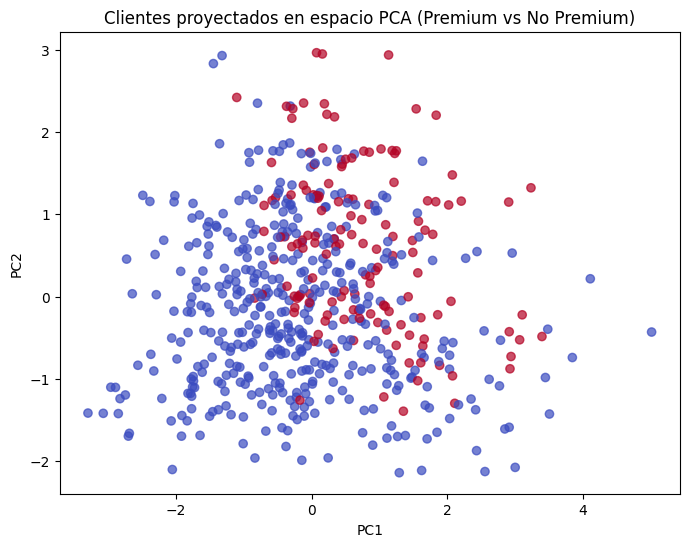

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="coolwarm", alpha=0.7)
plt.title("Clientes proyectados en espacio PCA (Premium vs No Premium)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
